In [216]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
raw_df = pd.read_csv("../data/content.csv")
pvs = pd.read_csv('../data/pvs.csv')
visits = pd.read_csv('../data/visits.csv')

,contentID,URL,headline,author,cmsCategories,nl_category_structured,nl_category
0,www.arkansasonline.com/news/2018/aug/23/sherif...,https://www.arkansasonline.com/news/2018/aug/2...,14-year-old dies days after being accidentally...,Jaime Dunaway,"/News, /News/Arkansas, /News/Arkansas/Southeast",NaN,NaN
1,www.arkansasonline.com/news/2018/aug/25/woods-...,https://www.arkansasonline.com/news/2018/aug/2...,Woods impresses despite stumbles,Tom Murphy,"/Sports, /Sports/College/Football, /Sports/Col...",NaN,NaN
2,www.arkansasonline.com/news/2018/aug/25/newton...,https://www.arkansasonline.com/news/2018/aug/2...,Newton has injury scare; Panthers win,The Associated Press,"/Sports, /Sports/Pros/Football",NaN,NaN
3,www.arkansasonline.com/news/2018/aug/24/arkans...,https://www.arkansasonline.com/news/2018/aug/2...,North Little Rock man accidentally shoots moth...,Jaime Dunaway,"None/Nlr, /News, /News/Arkansas, /News/Arkansa...",NaN,NaN
4,www.arkansasonline.com/news/2018/aug/25/wolver...,https://www.arkansasonline.com/news/2018/aug/2...,Wolverines depending on ex-Ole Miss QB Patterson,The Associated Press,"/Sports, /Sports/College/Football",NaN,NaN
...,...,...,...,...,...,...,...
16542,www.arkansasonline.com/news/2018/jun/29/five-m...,https://www.arkansasonline.com/news/2018/jun/2...,Five more movie classics finally screened,PIERS MARCHANT Special to the Democrat-Gazette,"/Entertainment/Movies,",/Arts & Entertainment/Movies,/Arts & Entertainment/Movies
16543,www.arkansasonline.com/news/2018/jul/29/kavana...,https://www.arkansasonline.com/news/2018/jul/2...,Kavanaugh rulings a hit for NRA,MICHAEL KUNZELMAN and LARRY NEUMEISTER The Ass...,"/News/National, /News/Politics/National","/Law & Government, /News/Politics","/Law & Government, /News/Politics"
16544,www.arkansasonline.com/news/2018/sep/09/he-s-g...,https://www.arkansasonline.com/news/2018/sep/0...,He's gonna get in trouble with this,The San Diego Union-Tribune,"/Editorial, /Editorial/Columns","/News/Politics, /Law & Government","/News/Politics, /Law & Government"
16545,www.arkansasonline.com/news/2017/oct/29/blind-...,https://www.arkansasonline.com/news/2017/oct/2...,RIGHT TIME RIGHT PLACE: RIGHT TIME RIGHT PLACE...,Kimberly Dishongh,/Entertainment/Features/Highprofile,NaN,NaN


# Basic data cleaning and processing
### Clean the visit records and page view records

In [3]:
# There are 346609 page views
pvs.head() # 346609 rows × 3 columns

,visitID,visitorID,contentID
0,1531854699,2.011047e+14,www.arkansasonline.com/news/2018/jul/17/author...
1,1532645198,2.011047e+14,www.arkansasonline.com/news/2011/nov/15/walton...
2,1533148392,2.011047e+14,www.arkansasonline.com/news/2018/aug/01/blaze-...
3,1533827139,2.011047e+14,www.arkansasonline.com/news/2018/aug/08/sherif...
4,1533827139,2.011047e+14,www.arkansasonline.com/news/2018/aug/09/top-6-...


In [15]:
pvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346609 entries, 0 to 346608
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   visitID    346609 non-null  int64  
 1   visitorID  346609 non-null  float64
 2   contentID  293731 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 7.9+ MB


A lot of page views are missing `contentID`.

In [4]:
# There are 256121 visits
visits.head() # 256121 rows × 10 columns
# keep the 'visitID', 'visitorID' and 'visitDateTime' columns
visits = visits[['visitID', 'visitorID', 'visitDateTime']]

In [31]:
print(f"The earlist records: {min(visits['visitDateTime'])}")
print(f"The latest records: {max(visits['visitDateTime'])}")

The earlist records: 2018-07-01T05:02:22Z
The latest records: 2018-10-01T04:45:18Z


In [16]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256121 entries, 0 to 256120
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   visitID        256121 non-null  int64  
 1   visitorID      256121 non-null  float64
 2   visitDateTime  256121 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.9+ MB


There are no missing values in visit records.

Each visit may have more than one page view.
Then, left join the visit records on the page view records and drop incomplete rows to get the complete visit records with visit time. 

In [11]:
# join the page views and visits together to know the time for each page view
user_visits = pd.merge(pvs,visits, on = ('visitorID','visitID'), how='left').dropna().reset_index(drop=True)
user_visits

,visitID,visitorID,contentID,visitDateTime
0,1531854699,2.011047e+14,www.arkansasonline.com/news/2018/jul/17/author...,2018-07-17T19:11:39Z
1,1532645198,2.011047e+14,www.arkansasonline.com/news/2011/nov/15/walton...,2018-07-26T22:46:38Z
2,1533148392,2.011047e+14,www.arkansasonline.com/news/2018/aug/01/blaze-...,2018-08-01T18:33:12Z
3,1533827139,2.011047e+14,www.arkansasonline.com/news/2018/aug/08/sherif...,2018-08-09T15:05:39Z
4,1533827139,2.011047e+14,www.arkansasonline.com/news/2018/aug/09/top-6-...,2018-08-09T15:05:39Z
...,...,...,...,...
293032,1537018622,1.805825e+19,www.arkansasonline.com/news/2018/sep/15/key-pi...,2018-09-15T13:37:02Z
293033,1537285726,1.805825e+19,www.arkansasonline.com/news/2018/sep/18/distri...,2018-09-18T15:48:46Z
293034,1537298388,1.805825e+19,www.arkansasonline.com/news/2018/sep/18/little...,2018-09-18T19:19:48Z
293035,1537318704,1.805825e+19,www.arkansasonline.com/news/2018/sep/18/nation...,2018-09-19T00:58:24Z


### Basic cleaning on the article features

In [17]:
# Remove redundant article titles and only keep one title for each article
content_df = raw_df.drop_duplicates(subset='contentID', keep='first', inplace=False)  # 12491 rows × 7 columns
content_df.head()

,contentID,URL,headline,author,cmsCategories,nl_category_structured,nl_category
0,www.arkansasonline.com/news/2018/aug/23/sherif...,https://www.arkansasonline.com/news/2018/aug/2...,14-year-old dies days after being accidentally...,Jaime Dunaway,"/News, /News/Arkansas, /News/Arkansas/Southeast",NaN,NaN
1,www.arkansasonline.com/news/2018/aug/25/woods-...,https://www.arkansasonline.com/news/2018/aug/2...,Woods impresses despite stumbles,Tom Murphy,"/Sports, /Sports/College/Football, /Sports/Col...",NaN,NaN
2,www.arkansasonline.com/news/2018/aug/25/newton...,https://www.arkansasonline.com/news/2018/aug/2...,Newton has injury scare; Panthers win,The Associated Press,"/Sports, /Sports/Pros/Football",NaN,NaN
3,www.arkansasonline.com/news/2018/aug/24/arkans...,https://www.arkansasonline.com/news/2018/aug/2...,North Little Rock man accidentally shoots moth...,Jaime Dunaway,"None/Nlr, /News, /News/Arkansas, /News/Arkansa...",NaN,NaN
4,www.arkansasonline.com/news/2018/aug/25/wolver...,https://www.arkansasonline.com/news/2018/aug/2...,Wolverines depending on ex-Ole Miss QB Patterson,The Associated Press,"/Sports, /Sports/College/Football",NaN,NaN


There are 12491 articles from browsing records.

In [25]:
content_df['author'].value_counts() # There are 1436 authors
content_df['author'].isnull().sum() # There are 1519 articles with missing author records

The Associated Press                                                        687
The Associated Press                                                        514
Arkansas Democrat-Gazette                                                   371
Jaime Dunaway                                                               328
Abigail Van Buren                                                           303
                                                                           ... 
Special to NWA Democrat-Gazette                                               1
Phyllis Brandon                                                               1
LOLITA C. BALDOR, AHN YOUNG-JOON and KIM TONG-HYUNG The Associated Press      1
STUART LEAVENWORTH TRIBUNE NEWS SERVICE                                       1
BROOKS BARNES THE NEW YORK TIMES                                              1
Name: author, Length: 1436, dtype: int64

In [18]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12491 entries, 0 to 16546
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   contentID               12491 non-null  object
 1   URL                     12491 non-null  object
 2   headline                12491 non-null  object
 3   author                  10972 non-null  object
 4   cmsCategories           12485 non-null  object
 5   nl_category_structured  2200 non-null   object
 6   nl_category             2200 non-null   object
dtypes: object(7)
memory usage: 780.7+ KB


There are a lot null values in `nl_category_structured` and `nl_category` columns so I will drop these two columns

In [19]:
# replace the null values in the categories with spaces
# build the article profile based on article titles and article types 
# combine all the categories into one column and remove the rest category columns
content_df = content_df.fillna(' ')
content_df['categories'] = content_df['cmsCategories']+ content_df['nl_category_structured']+content_df['nl_category']
del content_df['cmsCategories']
del content_df['nl_category_structured']
del content_df['nl_category']
del content_df['URL']
del content_df['author']
content_df = content_df.reset_index(drop=True)

In [20]:
content_df

,contentID,headline,categories
0,www.arkansasonline.com/news/2018/aug/23/sherif...,14-year-old dies days after being accidentally...,"/News, /News/Arkansas, /News/Arkansas/Southeast"
1,www.arkansasonline.com/news/2018/aug/25/woods-...,Woods impresses despite stumbles,"/Sports, /Sports/College/Football, /Sports/Col..."
2,www.arkansasonline.com/news/2018/aug/25/newton...,Newton has injury scare; Panthers win,"/Sports, /Sports/Pros/Football"
3,www.arkansasonline.com/news/2018/aug/24/arkans...,North Little Rock man accidentally shoots moth...,"None/Nlr, /News, /News/Arkansas, /News/Arkansa..."
4,www.arkansasonline.com/news/2018/aug/25/wolver...,Wolverines depending on ex-Ole Miss QB Patterson,"/Sports, /Sports/College/Football"
...,...,...,...
12486,www.arkansasonline.com/news/2018/jun/29/five-m...,Five more movie classics finally screened,"/Entertainment/Movies, /Arts & Entertainment/M..."
12487,www.arkansasonline.com/news/2018/jul/29/kavana...,Kavanaugh rulings a hit for NRA,"/News/National, /News/Politics/National/Law & ..."
12488,www.arkansasonline.com/news/2018/sep/09/he-s-g...,He's gonna get in trouble with this,"/Editorial, /Editorial/Columns/News/Politics, ..."
12489,www.arkansasonline.com/news/2017/oct/29/blind-...,RIGHT TIME RIGHT PLACE: RIGHT TIME RIGHT PLACE...,/Entertainment/Features/Highprofile


### Completed records
Inner join the article content records with visit records

In [35]:
total_info = pd.merge(content_df,user_visits, on = ('contentID'), how='inner').sort_values('visitDateTime').reset_index(drop=True)
total_info['visitDateTime'] = pd.to_datetime(total_info['visitDateTime']).dt.date
total_info.head()

,contentID,headline,categories,visitID,visitorID,visitDateTime
0,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
1,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
2,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
3,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
4,www.arkansasonline.com/news/2018/jun/30/suspec...,Suspect arrested in fatal shooting in Pulaski ...,/News/Arkansas/Crime,1530422162,9.015515e+18,2018-07-01


In [231]:
total_info

,contentID,headline,categories,visitID,visitorID,visitDateTime
0,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
1,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
2,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
3,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
4,www.arkansasonline.com/news/2018/jun/30/suspec...,Suspect arrested in fatal shooting in Pulaski ...,/News/Arkansas/Crime,1530422162,9.015515e+18,2018-07-01
...,...,...,...,...,...,...
292779,www.arkansasonline.com/news/2018/sep/30/buffal...,Buffalo ribs with Cam,"/Editorial, /Editorial/Columns, /Editorial/Col...",1538367030,3.903908e+18,2018-10-01
292780,www.arkansasonline.com/news/2018/sep/30/foster...,"In Arkansas, foster youths who age out often a...",/News/Arkansas/People & Society/People & Society,1538367692,6.027405e+16,2018-10-01
292781,www.arkansasonline.com/news/2018/sep/30/foster...,"In Arkansas, foster youths who age out often a...",/News/Arkansas/People & Society/People & Society,1538367692,6.027405e+16,2018-10-01
292782,www.arkansasonline.com/news/2018/sep/30/foster...,"In Arkansas, foster youths who age out often a...",/News/Arkansas/People & Society/People & Society,1538367692,6.027405e+16,2018-10-01


In [36]:
total_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292784 entries, 0 to 292783
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   contentID      292784 non-null  object 
 1   headline       292784 non-null  object 
 2   categories     292784 non-null  object 
 3   visitID        292784 non-null  int64  
 4   visitorID      292784 non-null  float64
 5   visitDateTime  292784 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 13.4+ MB


In [37]:
total_info.nunique()

contentID         11455
headline          10280
categories         2221
visitID          106555
visitorID          3421
visitDateTime        93
dtype: int64

In [38]:
print(f"The earlist records: {min(total_info['visitDateTime'])}")
print(f"The latest records: {max(total_info['visitDateTime'])}")

The earlist records: 2018-07-01
The latest records: 2018-10-01


In [230]:
# total_info.to_csv("../data/total_info.csv")
total_info.drop_duplicates(subset=('visitID','visitorID','visitDateTime'), keep='first', inplace=False)

,contentID,headline,categories,visitID,visitorID,visitDateTime
0,www.arkansasonline.com/news/2018/jun/30/arrest...,Arrested state legislator urged to quit post,"/News/Arkansas, /News/Politics/Arkansas/Law & ...",1530421855,5.364833e+18,2018-07-01
4,www.arkansasonline.com/news/2018/jun/30/suspec...,Suspect arrested in fatal shooting in Pulaski ...,/News/Arkansas/Crime,1530422162,9.015515e+18,2018-07-01
5,www.arkansasonline.com/news/2018/jun/30/police...,Police: Officer fatally shoots self at central...,/News/Arkansas/Law & Government/Public Safety/...,1530423657,1.343160e+18,2018-07-01
9,www.arkansasonline.com/news/2018/may/03/1-kill...,Driver dies after losing control of Corvette i...,"/News/Arkansas, /News/Fatalwrecks, /Social",1530423935,4.705169e+18,2018-07-01
13,www.arkansasonline.com/news/2018/apr/24/facebo...,Facebook profile lands Arkansas sex offender i...,"/News/Arkansas, /News/Arkansas/Crime/Law & Gov...",1530424161,4.705169e+18,2018-07-01
...,...,...,...,...,...,...
292773,www.arkansasonline.com/news/2018/sep/30/deadli...,Deadline looms; health coverage at risk for many,"/News/Arkansas, /News/Healthcare",1538366477,9.595882e+15,2018-10-01
292774,www.arkansasonline.com/news/2018/sep/29/texas-...,Texas A&M;'s six-year reign,"/Sports, /Sports/College/Razorbacks/Razobacks-...",1538366670,5.290775e+17,2018-10-01
292778,www.arkansasonline.com/news/2018/sep/30/means-...,Means to an end,"/Editorial, /Editorial/Columns, /Editorial/Col...",1538367023,3.903908e+18,2018-10-01
292779,www.arkansasonline.com/news/2018/sep/30/buffal...,Buffalo ribs with Cam,"/Editorial, /Editorial/Columns, /Editorial/Col...",1538367030,3.903908e+18,2018-10-01


### Split the records into training set, validation set and test set

As the records are collected during 3 months (93 days). I will split the record  into training set, validation set and test set according to the ratio of 70:15:15.

In [60]:
train_df = total_info.loc[total_info['visitDateTime'] <= pd.to_datetime('2018-09-03')]
valid_df = total_info.loc[(total_info['visitDateTime'] > pd.to_datetime('2018-09-03')) & (total_info['visitDateTime'] <= pd.to_datetime('2018-09-17'))]
test_df = total_info.loc[total_info['visitDateTime'] > pd.to_datetime('2018-09-17')]

In [69]:
print("train set")
print(f"{min(train_df['visitDateTime'])} - {max(train_df['visitDateTime'])}")
print(f"{(train_df['visitDateTime']).nunique()} days")
print(f"{(train_df['contentID']).nunique()} articles")
print(f"{(train_df['visitorID']).nunique()} visitors")
print("------------------")
print("valid set")
print(f"{min(valid_df['visitDateTime'])} - {max(valid_df['visitDateTime'])}")
print(f"{(valid_df['visitDateTime']).nunique()} days")
print(f"{(valid_df['contentID']).nunique()} articles")
print(f"{(valid_df['visitorID']).nunique()} visitors")
print("------------------")
print("test set")
print(f"{min(test_df['visitDateTime'])} - {max(test_df['visitDateTime'])}")
print(f"{(test_df['visitDateTime']).nunique()} days")
print(f"{(test_df['contentID']).nunique()} articles")
print(f"{(test_df['visitorID']).nunique()} visitors")

train set
2018-07-01 - 2018-09-03
65 days
8529 articles
2884 visitors
------------------
valid set
2018-09-04 - 2018-09-17
14 days
1853 articles
1868 visitors
------------------
test set
2018-09-18 - 2018-10-01
14 days
1773 articles
1625 visitors


# Exploratory Data Analysis

 

### The exploratory data ananlysis consists of 3 parts as shown below: </br>
1. Popularity (page visits) analysis </br>
a. Page visits of each articles</br>
How many page visits could an article have during the first 65 days? </br>
b. Page visits of each articles for individual visitors </br>
How many times does an individual visitor read the same article during the first 65 days?

2. Time lag (number of days between first visit ~ last visit)  effects </br>
a. Time lag distribution for articles whose last records are before 2018-09-03 </br>
b. Time lag distribution for articles whose last records are 2018-09-03 </br>
c. Time lag distribution for popular articles (page visits > 57) </br>
d. Time lag distribution for common articles (page visits < 57) </br>

3. Article content ananlysis </br>
a. Article headline features: the information in the article headlines </br>
b. Article category features: the information in the article categories </br>

In [84]:
# user profile for train set
train_utility = train_df[['visitorID','contentID','visitDateTime']]
train_utility

,visitorID,contentID,visitDateTime
0,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01
1,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01
2,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01
3,5.364833e+18,www.arkansasonline.com/news/2018/jun/30/arrest...,2018-07-01
4,9.015515e+18,www.arkansasonline.com/news/2018/jun/30/suspec...,2018-07-01
...,...,...,...
199931,3.796077e+18,www.arkansasonline.com/news/2018/sep/03/arkans...,2018-09-03
199932,2.077413e+18,www.arkansasonline.com/news/2018/sep/03/in-the...,2018-09-03
199933,2.149975e+18,www.arkansasonline.com/news/2018/sep/03/trump-...,2018-09-03
199934,8.539255e+18,www.arkansasonline.com/news/2018/sep/03/live-u...,2018-09-03


### 1. Popularity distribution
#### a. Let's have a look at the total page views for each article to see how popular an article could get?

In [188]:
popularity = train_utility.groupby('contentID').count()
popularity.columns = ['count1', 'count2']
popularity.sort_values('count1', ascending = False)

,count1,count2
contentID,,
www.arkansasonline.com/news/2018/aug/29/food-networks-diners-drive-ins-and-dives-stops-lit/,910,910
www.arkansasonline.com/news/2018/aug/31/former-arkansas-senator-jeremy-hutchinson-indicted/,734,734
www.arkansasonline.com/news/2018/aug/22/arkansas-democrat-gazette-delivery-man-shot-robbed/,656,656
www.arkansasonline.com/news/2018/jul/19/sheriff-8-people-dead-after-missouri-tourist-boat-/,594,594
www.arkansasonline.com/news/2018/aug/16/little-rock-police-helicopter-crashes-injuries-rep/,583,583
...,...,...
www.arkansasonline.com/news/2018/aug/12/look-for-1-of-big-3-to-win-in-michigan-/,1,1
www.arkansasonline.com/news/2018/aug/12/major-league-baseball-notes-20180812/,1,1
www.arkansasonline.com/news/2018/aug/12/mercy-earns-recognition-for-diabetes-pr/,1,1


In [190]:
popularity['count1'].describe() #(0,57)

count    8529.000000
mean       23.441904
std        47.857095
min         1.000000
25%         2.000000
50%         6.000000
75%        24.000000
max       910.000000
Name: count1, dtype: float64

Text(0.5, 1.0, 'The views distribution for all the articles in the traing set')

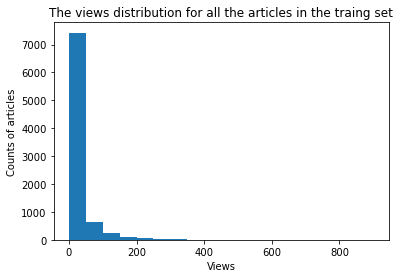

In [193]:
plt.hist(popularity['count1'], bins = range(0,950,50))
plt.xlabel('Views')
plt.ylabel('Counts of articles')
plt.title("The views distribution for all the articles in the traing set")

It can be seen that most articles have page visits between 0 and 50. The upperlimit for page visits = Q3+1.5IQR = 24+1.5*22 = 57. As a result, articles with page visits more than 57 could be taken as popular articles.

#### b. Then, have a look at the total page views for each article for each user

In [237]:
popular_ind = train_df.groupby(['visitorID','contentID']).count().sort_values('headline', ascending = False)
popular_ind.head()

headline  \
visitorID    contentID                                                      
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...       196   
             www.arkansasonline.com/news/2018/sep/02/white-f...       180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...       132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...       124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...       120   

                                                                 categories  \
visitorID    contentID                                                        
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...         196   
             www.arkansasonline.com/news/2018/sep/02/white-f...         180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...         132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...         124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...         120   

                                                                 visitID  \
visitorID    contentID                                                     
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...      196   
             www.arkansasonline.com/news/2018/sep/02/white-f...      180   
             www.arkansasonline.com/news/2018/aug/03/obama-s...      132   
             www.arkansasonline.com/news/2018/aug/10/cotton-...      124   
             www.arkansasonline.com/news/2018/aug/24/cotton-...      120   

                                                                 visitDateTime  
visitorID    contentID                                                          
6.335347e+18 www.arkansasonline.com/news/2018/aug/07/a-messa...            196  
             www.arkansasonline.com/news/2018/sep/02/white-f...            180  
             www.arkansasonline.com/news/2018/aug/03/obama-s...            132  
             www.arkansasonline.com/news/2018/aug/10/cotton-...            124  
             www.arkansasonline.com/news/2018/aug/24/cotton-...            120

In [258]:
popular_ind_avg = pd.DataFrame(popular_ind.groupby('visitorID')['headline'].mean().sort_values(ascending=False))
popular_ind_avg.columns = ['avg_views']
popular_ind_avg

,avg_views
visitorID,
5.393418e+18,32.000000
5.899972e+18,17.454545
4.720442e+18,16.290323
4.424965e+18,16.257143
4.238538e+18,16.000000
...,...
8.328446e+18,1.000000
2.856705e+18,1.000000
2.861615e+18,1.000000


In [260]:
popular_ind_avg['avg_views'].describe()

count    2884.000000
mean        1.877603
std         1.705857
min         1.000000
25%         1.000000
50%         1.048074
75%         1.539263
max        32.000000
Name: avg_views, dtype: float64

Text(0.5, 1.0, 'The average views for individual visitors')

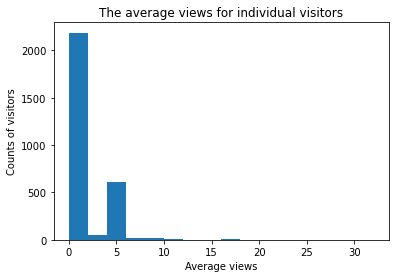

In [262]:
plt.hist(popular_ind_avg['avg_views'], bins = range(0,33,2))
plt.xlabel('Average views')
plt.ylabel('Counts of visitors')
plt.title("The average views for individual visitors")

For each visitor, the average view for each article is 2 views and most visitors don't read the same article for more than 1.5 times. As a result, it is reasonable to recommend articles that individual visitors haven't read.

### 2. Time lag distribution for all the articles
In this section, it is assumed that the first record of each article occurs on the day when the article is first released. </br>
Let's see the time effects on all the article views to decide whether users are more likely view new article than old articles. 

In [194]:
article_lag = pd.DataFrame(train_utility.groupby('contentID')['visitDateTime']
                           .agg(np.ptp)).sort_values('visitDateTime', ascending = False)
article_lag = article_lag.rename(columns={'visitDateTime':'lag'})
article_lag.head()

,lag
contentID,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60 days
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59 days
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58 days
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58 days
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58 days


In [195]:
article_s_e = train_utility.groupby('contentID').agg({'visitDateTime': ['min', 'max', 'count']}) 
article_s_e.columns = ['min','max','count']
article_s_e.head()

,min,max,count
contentID,,,
www.arkansasonline.com/news/2000/may/10/gun-maker-grandfather-dropped-school-shooting-suit/,2018-07-18,2018-07-18,2
www.arkansasonline.com/news/2007/aug/10/restaurants-thrill-grill-fades-butcher-sh-20070810/,2018-07-25,2018-07-25,1
www.arkansasonline.com/news/2007/dec/15/personal-space-20071215/,2018-08-09,2018-08-09,1
www.arkansasonline.com/news/2007/feb/17/our-town-north-little-rock-notebook-20070217/,2018-08-09,2018-08-09,1
www.arkansasonline.com/news/2007/jul/29/summary-2007-general-session-arkansas-legislature/,2018-07-23,2018-07-23,1


In [196]:
article_s_e.sort_values('count', ascending = False)

,min,max,count
contentID,,,
www.arkansasonline.com/news/2018/aug/29/food-networks-diners-drive-ins-and-dives-stops-lit/,2018-08-29,2018-09-03,910
www.arkansasonline.com/news/2018/aug/31/former-arkansas-senator-jeremy-hutchinson-indicted/,2018-08-31,2018-09-03,734
www.arkansasonline.com/news/2018/aug/22/arkansas-democrat-gazette-delivery-man-shot-robbed/,2018-08-22,2018-08-28,656
www.arkansasonline.com/news/2018/jul/19/sheriff-8-people-dead-after-missouri-tourist-boat-/,2018-07-20,2018-08-01,594
www.arkansasonline.com/news/2018/aug/16/little-rock-police-helicopter-crashes-injuries-rep/,2018-08-16,2018-08-21,583
...,...,...,...
www.arkansasonline.com/news/2018/aug/12/look-for-1-of-big-3-to-win-in-michigan-/,2018-08-12,2018-08-12,1
www.arkansasonline.com/news/2018/aug/12/major-league-baseball-notes-20180812/,2018-08-12,2018-08-12,1
www.arkansasonline.com/news/2018/aug/12/mercy-earns-recognition-for-diabetes-pr/,2018-08-13,2018-08-13,1


In [197]:
articles_s_e_l = pd.merge(article_lag, article_s_e, on = ('contentID'), how = 'inner')
articles_s_e_l.columns = ['lag','min','max','count']
articles_s_e_l['lag'] = pd.to_numeric(articles_s_e_l['lag'].dt.days, downcast='integer')
articles_s_e_l.head()

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59,2018-07-01,2018-08-29,16
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58,2018-07-02,2018-08-29,7
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58,2018-07-02,2018-08-29,5
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99



#### a. Time lag distribution for the articles whose records are before the end day of the training period (2018-09-03)

First, have a look at the articles whose last records are before the end day (2018-09-03) of training set 

In [179]:
training_before_last_day = articles_s_e_l.loc[articles_s_e_l['max'] < pd.to_datetime('2018-09-03')]
training_before_last_day

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59,2018-07-01,2018-08-29,16
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58,2018-07-02,2018-08-29,7
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58,2018-07-02,2018-08-29,5
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99
...,...,...,...,...
www.arkansasonline.com/news/2018/aug/26/splitting-dinner-bills-tricky-separate-/,0,2018-08-26,2018-08-26,4
www.arkansasonline.com/news/2018/aug/26/s-korea-urges-u-s-north-to-keep-talking/,0,2018-08-26,2018-08-26,6
www.arkansasonline.com/news/2018/aug/26/road-to-becoming-physician-starts-with-/,0,2018-08-26,2018-08-26,15


In [180]:
training_before_last_day['lag'].describe()

count    8338.000000
mean        2.948909
std         6.950313
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        60.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for articles whose last records are before 2018-09-03')

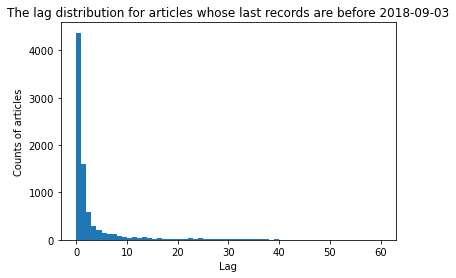

In [165]:
plt.hist(training_before_last_day['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of articles')
plt.title("The lag distribution for articles whose last records are before 2018-09-03")

It is obvious that the effects of most articles last for 0-2 days, which means that users are likely to view new-released articles instead of articles that have published for a long time.

#### b. Time lag distribution for the articles whose records are the end day of the training period
Then, have a look at the articles whose last records are the end day (2018-09-03) of training set to see if there is any difference. 

In [198]:
training_last_day = articles_s_e_l.loc[articles_s_e_l['max'] == pd.to_datetime('2018-09-03')]
training_last_day.head()

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/24/indiana-man-stabbed-north-little-rock-homeless-cam/,41,2018-07-24,2018-09-03,96
www.arkansasonline.com/news/2018/jul/29/cannabis-question-is-college-a-school-2-1/,36,2018-07-29,2018-09-03,131
www.arkansasonline.com/news/2018/aug/05/1-dead-3-injured-after-boat-capsizes-river-arkansa/,29,2018-08-05,2018-09-03,215
www.arkansasonline.com/news/2018/aug/06/state-s-medicaid-spending-falls-off-201/,28,2018-08-06,2018-09-03,192
www.arkansasonline.com/news/2018/aug/15/arkansas-man-accused-imprisoning-beating-woman-sen/,19,2018-08-15,2018-09-03,71


In [167]:
training_last_day['lag'].describe()

count    191.000000
mean       2.701571
std        5.704103
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       41.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for articles whose last records are on 2018-09-03')

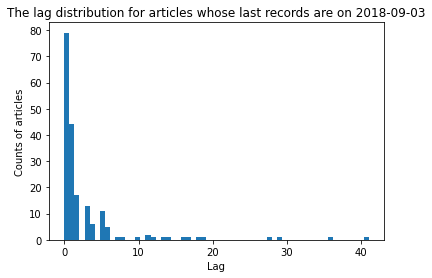

In [169]:
plt.hist(training_last_day['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of articles')
plt.title("The lag distribution for articles whose last records are on 2018-09-03")

As can seen, it still follows the same distribution. </br> As a result, it is safe to say that most articles only have short effects which last for 0-3 days.

#### c. Time lags for popular articles

Then, let's see if there is any difference in lag distribution for popular articles and common articles.

In [199]:
articles_s_e_l.head()

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/01/real-estate-transactions-20180701/,59,2018-07-01,2018-08-29,16
www.arkansasonline.com/news/2018/may/18/traffic-alert-3-vehicle-crash-fire-shuts-part-i-30/,58,2018-07-02,2018-08-29,7
www.arkansasonline.com/news/2018/jun/20/woman-brandishes-screwdriver-robbery-north-little-/,58,2018-07-02,2018-08-29,5
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99


In [204]:
popular_articles = articles_s_e_l.loc[articles_s_e_l['count'] > 57]
popular_articles

,lag,min,max,count
contentID,,,,
www.arkansasonline.com/news/2018/jul/01/dad-marches-in-lr-because-son-hides-und/,60,2018-07-01,2018-08-30,62
www.arkansasonline.com/news/2018/jul/06/outcomes-of-aspire-tests-seen-as-mixed-/,58,2018-07-06,2018-09-02,99
www.arkansasonline.com/news/2018/jul/05/photos-blaze-damaged-arkansas-home-was-started-fir/,55,2018-07-05,2018-08-29,63
www.arkansasonline.com/news/2018/jul/06/burges-opens-third-location-conway/,54,2018-07-06,2018-08-29,168
www.arkansasonline.com/news/2018/jul/07/hospital-ex-employee-subject-of-data-in/,53,2018-07-07,2018-08-29,109
...,...,...,...,...
www.arkansasonline.com/news/2018/aug/02/flight-to-concert-was-intent-of-plane-t/,0,2018-08-02,2018-08-02,73
www.arkansasonline.com/news/2018/aug/15/lawsuit-filed-on-work-rule-for-medicaid/,0,2018-08-15,2018-08-15,88
www.arkansasonline.com/news/2018/aug/08/eatery-worker-s-illness-prompts-new-hea-1/,0,2018-08-08,2018-08-08,62


There are 899 popular articles in the training set (page views > 57, which is the upperlimit)

In [213]:
popular_des = popular_articles['lag'].describe()
popular_des

count    899.000000
mean       6.620690
std        8.704993
min        0.000000
25%        1.000000
50%        3.000000
75%        7.500000
max       60.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for popular articles (counts > 57)')

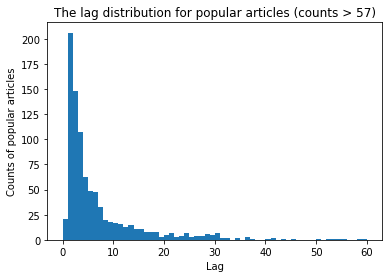

In [206]:
plt.hist(popular_articles['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of popular articles')
plt.title("The lag distribution for popular articles (counts > 57)")

For popular articles, the average lag is longer, about 7 days.

#### d. Time lags for common articles

In [212]:
common_articles = articles_s_e_l.loc[articles_s_e_l['count'] <= 57]
common_des = common_articles['lag'].describe()
common_des

count    7630.000000
mean        2.510092
std         6.549875
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        59.000000
Name: lag, dtype: float64

Text(0.5, 1.0, 'The lag distribution for common articles (counts <= 57)')

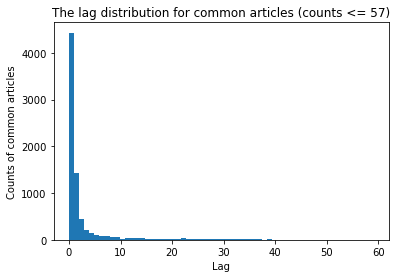

In [208]:
plt.hist(common_articles['lag'], bins = 60)
plt.xlabel('Lag')
plt.ylabel('Counts of common articles')
plt.title("The lag distribution for common articles (counts <= 57)")

Let's see if the lags for popular articles and for common articles follow the same distribution. 


In [228]:
common_des
popular_des
S_p_c = math.sqrt(popular_des['std']**2/popular_des['count']+common_des['std']**2/common_des['count'])
t_popularity = abs(popular_des['mean']-common_des['mean'])/S_p_c
t_popularity
print(f"The t value is {round(t_popularity,2)}, which is much larger than the critical t value (1.96). It means that the article views for popular articles and common articles follow different distributions")

The t value is 13.71, which is much larger than the critical t value (1.96). It means that the article views for popular articles and common articles follow different distributions


Aa a result, it may be reasonable to recommend previous popular articles even after a week from the day the article is released, but for common articles, the effects normally last only 0-2.5 days.

### 3. Articles Content Analysis

a. Articles headline analysis

In [314]:
train_articles_df = train_df.drop_duplicates(subset='contentID', keep='first', inplace=False)[['contentID', 'headline', 'categories']].reset_index(drop=True)
val_articles_df = valid_df.drop_duplicates(subset='contentID', keep='first', inplace=False)[['contentID', 'headline', 'categories']].reset_index(drop=True)

In [323]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst2 if value in lst1] 
    return lst3 
train_articles = list(train_articles_df['contentID'].unique())
val_articles = list(val_articles_df['contentID'].unique())
val_old_articles = intersection(train_articles, val_articles) 
len(val_old_articles)

338

In [324]:
val_new_articles_df = val_articles_df[~val_articles_df['contentID'].isin(val_old_articles)]
val_old_articles_df = val_articles_df[val_articles_df['contentID'].isin(val_old_articles)]

In [325]:
val_new_articles_df.head() # 1515 new articles

,contentID,headline,categories
5,www.arkansasonline.com/news/2007/aug/09/malak-...,The Malak factor,"/Subscriber/Columnists, /Subscriber/Opinion"
6,www.arkansasonline.com/news/2007/oct/30/beebe-...,Beebe says investigation into teen's 1989 deat...,/News/Arkansas
14,www.arkansasonline.com/news/2018/aug/23/trump-...,Trump lauds Medal of Honor recipient,/News/National
41,www.arkansasonline.com/news/2018/sep/03/suspic...,'Suspicious death' of female in Little Rock be...,"None/Lr, /News/Arkansas, /News/Arkansas/Crime"
48,www.arkansasonline.com/news/2018/sep/03/lr-pol...,LR Police investigate homicide,/News/Arkansas


In [326]:
train_articles

['www.arkansasonline.com/news/2018/jun/30/arrested-lawmaker-urged-to-quit-post-20/',
 'www.arkansasonline.com/news/2018/jun/30/suspect-arrested-fatal-shooting-pulaski-county/',
 'www.arkansasonline.com/news/2018/jun/30/police-officer-fatally-shoots-self-central-arkansa/',
 'www.arkansasonline.com/news/2018/jun/30/motorcyclist-killed-head-crash-little-rock-suv-dri/',
 'www.arkansasonline.com/news/2018/jun/30/early-offer-gets-highly-recruited-receiver-campus-/',
 'www.arkansasonline.com/news/2018/may/03/1-killed-1-injured-killed-when-car-runs-curve-sout/',
 'www.arkansasonline.com/news/2018/apr/24/facebook-profile-lands-arkansas-sex-offender-jail-/',
 'www.arkansasonline.com/news/2018/jun/30/3-motorcyclists-among-highway-deaths-20/',
 'www.arkansasonline.com/news/2018/jun/30/cupcakes-idea-takes-boot-camp-top-prize/',
 'www.arkansasonline.com/news/2018/jun/30/steel-mill-to-expand-add-500-new-worker/',
 'www.arkansasonline.com/news/2018/jul/01/panama-canal-prepares-for-surge-in-lng-/',
 'w

In [328]:
len_headline_train = train_articles_df['headline'].str.len()
len_headline_train.describe()

count    8529.000000
mean       51.781569
std        25.634907
min         2.000000
25%        34.000000
50%        50.000000
75%        67.000000
max       178.000000
Name: headline, dtype: float64

Text(0, 0.5, 'Counts of articles')

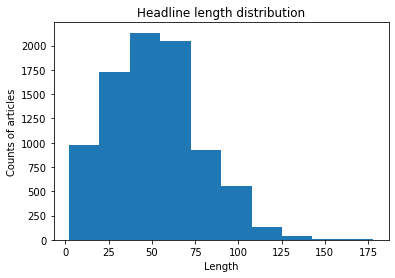

In [329]:
plt.hist(len_headline_train) 
plt.title("Headline length distribution")
plt.xlabel("Length")
plt.ylabel("Counts of articles")

Most articles headlines are around 50 words.

Text(0.5, 1.0, 'Article keywords in training set')

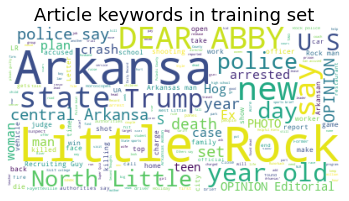

In [331]:
wordcloud1 = WordCloud(background_color='white').generate(" ".join(train_articles_df['headline']))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Article keywords in training set',fontsize=18)

### Make headline lowercase and remove links, punctuation, etc.

In [332]:
# data cleaning
# 
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and train datasets
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x: clean_text(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x: clean_text(x))

# updated text
train_articles_df['headline'].head()

0         arrested state legislator urged to quit post
1    suspect arrested in fatal shooting in pulaski ...
2    police officer fatally shoots self at central ...
3    motorcyclist killed in headon crash in little ...
4    the recruiting guy early offer gets highly rec...
Name: headline, dtype: object

In [333]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x:tokenizer.tokenize(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x:tokenizer.tokenize(x))
train_articles_df['headline'].head()

0    [arrested, state, legislator, urged, to, quit,...
1    [suspect, arrested, in, fatal, shooting, in, p...
2    [police, officer, fatally, shoots, self, at, c...
3    [motorcyclist, killed, in, headon, crash, in, ...
4    [the, recruiting, guy, early, offer, gets, hig...
Name: headline, dtype: object

### Remove stopwords

In [337]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [336]:
len(stopwords.words('english'))

179

In [ ]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words 
train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x : remove_stopwords(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x : remove_stopwords(x))

In [340]:
train_articles_df.head()

,contentID,headline,categories
0,www.arkansasonline.com/news/2018/jun/30/arrest...,"[arrested, state, legislator, urged, quit, post]","/News/Arkansas, /News/Politics/Arkansas/Law & ..."
1,www.arkansasonline.com/news/2018/jun/30/suspec...,"[suspect, arrested, fatal, shooting, pulaski, ...",/News/Arkansas/Crime
2,www.arkansasonline.com/news/2018/jun/30/police...,"[police, officer, fatally, shoots, self, centr...",/News/Arkansas/Law & Government/Public Safety/...
3,www.arkansasonline.com/news/2018/jun/30/motorc...,"[motorcyclist, killed, headon, crash, little, ...","/News/Arkansas, /News/Arkansas/Crime"
4,www.arkansasonline.com/news/2018/jun/30/early-...,"[recruiting, guy, early, offer, gets, highly, ...","None/Recruiting, /Sports/College/Razorbacks/Ra..."


### Lemmatization

In [341]:
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]
train_articles_df['headline'] = train_articles_df['headline'].apply(lem_word)
val_articles_df['headline'] = val_articles_df['headline'].apply(lem_word)
train_articles_df['headline']

0        [arrested, state, legislator, urged, quit, post]
1       [suspect, arrested, fatal, shooting, pulaski, ...
2       [police, officer, fatally, shoot, self, centra...
3       [motorcyclist, killed, headon, crash, little, ...
4       [recruiting, guy, early, offer, get, highly, r...
                              ...                        
8524               [ebola, survivor, face, stigma, congo]
8525            [korea, security, official, visit, north]
8526        [rockskipping, champ, coming, local, contest]
8527                    [run, skip, hop, get, registered]
8528       [injury, force, merrick, football, retirement]
Name: headline, Length: 8529, dtype: object

In [342]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train_articles_df['headline'] = train_articles_df['headline'].apply(lambda x : combine_text(x))
val_articles_df['headline'] = val_articles_df['headline'].apply(lambda x : combine_text(x))
train_articles_df['headline']

0               arrested state legislator urged quit post
1          suspect arrested fatal shooting pulaski county
2       police officer fatally shoot self central arka...
3       motorcyclist killed headon crash little rock s...
4       recruiting guy early offer get highly recruite...
                              ...                        
8524                     ebola survivor face stigma congo
8525                  korea security official visit north
8526              rockskipping champ coming local contest
8527                          run skip hop get registered
8528             injury force merrick football retirement
Name: headline, Length: 8529, dtype: object

### Count-vector

In [344]:
count_vectorizer = CountVectorizer()
train_vector = count_vectorizer.fit_transform(train_articles_df['headline'])
val_vector = count_vectorizer.transform(val_articles_df['headline'])
print(train_vector[0].todense())

In [345]:
train_vector[0].shape

(1, 9270)

### TF-IDF

In [348]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5,ngram_range = (1,2))
train_tfidf = tfidf.fit_transform(train_articles_df['headline'])
test_tfidf = tfidf.transform(val_articles_df['headline'])
train_tfidf

<1x8089 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>